<a id="inicio"></a>
<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Capstone V (Part 1)</font></h2>

<h1><font color="#00586D" size=5>Analysis and prediction of a data set on house prices</font></h1>
<br><br><br>


<div align="right">
<font color="#00586D" size=3>Luis de la Ossa</font><br>
<font color="#00586D" size=3>Master in Data Science and Data Engineering in the Cloud</font><br>
<font color="#00586D" size=3>University of Castilla-La Mancha</font>

</div>
<br>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

<a id="indice"></a>
<h2><font color="#00586D" size=5>Index</font></h2>

#### <font color="#00586D"> Notebook I</font>
*[1. Introduction](#section1)* [2. Data preparation](#section2)
*[3. Preliminary exploration](#section3)

#### <font color="#00586D"> Notebook II</font>
[4. Prediction with basic models](#section4)
*[5. Ensembles](#section5)* [6. Explainability](#section6)
*[7. KNN](#section7)* [8. Feature construction](#section8)
*[9. Discarding outliers](#section9)* [10. Unsupervised learning: PCA and EM](#section10)


---

<a id="section1"></a>
## <font color="#00586D"> 1. Introduction</font>
<br>

In this project a problem of analysis and prediction of housing prices will be addressed. The original data set has been obtained from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data), and is the basis of a contest that, as of today Today, it is still open (although without a prize). As you can read in the challenge description, this problem is suitable for working on creating features or using ensembles. In this project we will address these tasks, as well as others.

Finally, although a training set and a test set can be downloaded on the website, the latter is not labeled. Therefore, only the training and cross-validation set will be used. However, an interesting exercise would be to expand the project and submit the test prediction to compare with other results. It's also very interesting to take a look at work that people have done with this same data set, and that is available on Kaggle.


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> This first notebook only contains the description of the data preparation process. Therefore, **it is only about reading it, since it does not contain any exercises.**
</div>


The file `data/houses.csv` contains the data that will be worked with. As can be seen upon prior inspection, missing values ​​are encoded with the label `NA`, although this point will be discussed in more detail later.

In [2]:
df_houses = pd.read_csv('data/houses.csv', index_col=0, na_values='NA')
#df_houses.info()
df_houses.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
867,20,RL,67.0,10656,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2007,New,Partial,248900
667,60,RL,NaN,18450,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Abnorml,129000
226,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2009,COD,Abnorml,112000
629,60,RL,70.0,11606,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2007,WD,Family,135000
281,60,RL,82.0,11287,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,228500


---

<a id="section2"></a>
## <font color="#00586D"> 2. Preparation</font>


### <font color="#00586D">Data types</font>


It can be seen that the data set represents each home through 80 characteristics whose description can be found in the file `data/data_description.txt`. This information is also interesting in order to determine what type of data each of them must be represented with and, in some cases, what values ​​they can take.


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> This last circumstance is of special interest, since it allows us to greatly simplify the transformation *pipeline*, and dedicate the work to the construction of the models. However, to process the test data and submit the results, a *pipeline* would have to be built. This exercise will be left optional.
</div>


Although each characteristic is encoded with a data type, this may not correspond to the way it is to be treated. For example, the column `MSSubClass` represents the housing type using numerical values, yet it must be treated as discrete. On the other hand, there are discrete characteristics in which the possible values ​​have an order relationship, and it is not convenient to lose that information: these must be treated as ordinal (encoded with categories or with integers).

In this cell the different types of characteristics are established and the description of the ordinal values ​​is carried out. This (somewhat dry) inspection work has been carried out ***manually*** from the descriptions provided in the file `data/data_description.txt` (it is recommended to take a look).

In [3]:
# Características numéricas
numerical = ['LotFrontage', 'LotArea','OverallQual','OverallCond',
             'YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
             'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
             'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
             'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
             'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
             '3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold','SalePrice']

# Características categóricas (discretas)
discrete = ['MSSubClass','MSZoning','Street','Alley','LandContour', 'LotConfig',
            'Neighborhood', 'Condition1', 'Condition2','BldgType','HouseStyle',
            'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
            'Foundation','Heating','CentralAir','Electrical','GarageType','MiscFeature',
            'SaleType','SaleCondition']

# Características categóricas (ordinales)
ordinal = ['LotShape','Utilities', 'LandSlope','ExterQual','ExterCond','BsmtQual',
           'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
           'KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
           'GarageCond','PavedDrive','PoolQC','Fence']

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> In the case of ordinal characteristics, **it is important to maintain the order relationship of the** tags.
</div>


 This implies that, regardless of how and where the coding is done, this order must be provided. In this case, the initial *DataFrame* will be recoded to simplify subsequent code.

In [4]:
df_houses['LotShape'].replace({'IR3':1,'IR2':2,'IR1':3,'Reg':4}, inplace=True)
df_houses['Utilities'].replace({'ELO':1,'NoSeWa':2,'NoSewr':3,'AllPub':4}, inplace=True)
df_houses['LandSlope'].replace({'Gtl':1,'Mod':2,'Sev':3}, inplace=True)
df_houses['ExterQual'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['ExterCond'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['BsmtQual'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['BsmtCond'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['BsmtExposure'].replace({'No':1,'Mn':2,'Av':3, 'Gd':4}, inplace=True)
df_houses['BsmtFinType1'].replace({'Unf':1,'LwQ':2,'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
df_houses['BsmtFinType2'].replace({'Unf':1,'LwQ':2,'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
df_houses['HeatingQC'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['KitchenQual'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['Functional'].replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)
df_houses['FireplaceQu'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['GarageFinish'].replace({'Unf':1,'RFn':2,'Fin':3}, inplace=True)
df_houses['GarageQual'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['GarageCond'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['PavedDrive'].replace({'N':1,'P':2,'Y':3}, inplace=True)
df_houses['PoolQC'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['Fence'].replace({'MnWw':1,'GdWo':2,'MnPrv':3, 'GdPrv':4}, inplace=True)

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Important__: Although we have not yet done the training/test division, ***not***we are incurring coding errors or*data leakage*, since these categories are predefined and, therefore,**we assume** that it is the format in which all the data would arrive, including the new ones.
</div>

---

### <font color="#00586D">Null values</font>

The treatment of missing values ​​in this data set is special due to the different types of data, and the use made of the `NA` value in the original file. Although the first look at the data set shows that it does not contain missing values ​​as such, but rather the symbol `NA`, and that this has been treated as *NaN*, a look at the data types shows that, for some features, `NA` **is informative**. For example, in the case of `PoolQC`, which represents the quality of the pool, and which is the column with the most missing values, `NA` represents that there is no pool, and that `PoolArea` is equal to zero. Although we could do without this `PoolQC` column because `PoolArea` provides us with information, we can encode it correctly, so that the algorithms themselves determine whether the variable is relevant or not.

In order to deal with null or missing values, first look at the columns where these values ​​exist.

In [5]:
missing_vals = df_houses.isna().sum().sort_values(ascending=False).where(lambda n: n>0).dropna()
missing_vals

PoolQC          1453.0
MiscFeature     1406.0
Alley           1369.0
Fence           1179.0
FireplaceQu      690.0
LotFrontage      259.0
GarageYrBlt       81.0
GarageCond        81.0
GarageType        81.0
GarageFinish      81.0
GarageQual        81.0
BsmtExposure      38.0
BsmtFinType2      38.0
BsmtCond          37.0
BsmtQual          37.0
BsmtFinType1      37.0
MasVnrArea         8.0
MasVnrType         8.0
Electrical         1.0
dtype: float64

Before proceeding to deal with them, it is necessary to consider that the appearance or non-appearance of a value provides information of interest. The `missingno` library implements some utility functions to perform inspection.

In [6]:
!pip install missingno

import missingno as msno

Using the `msno.matrix()` function you can visualize the appearance of missing values ​​in the DataFrame. In this case, only the columns that contain missing values ​​will be displayed. Sometimes, sorting a column allows you to improve the visualization (in this case not much).

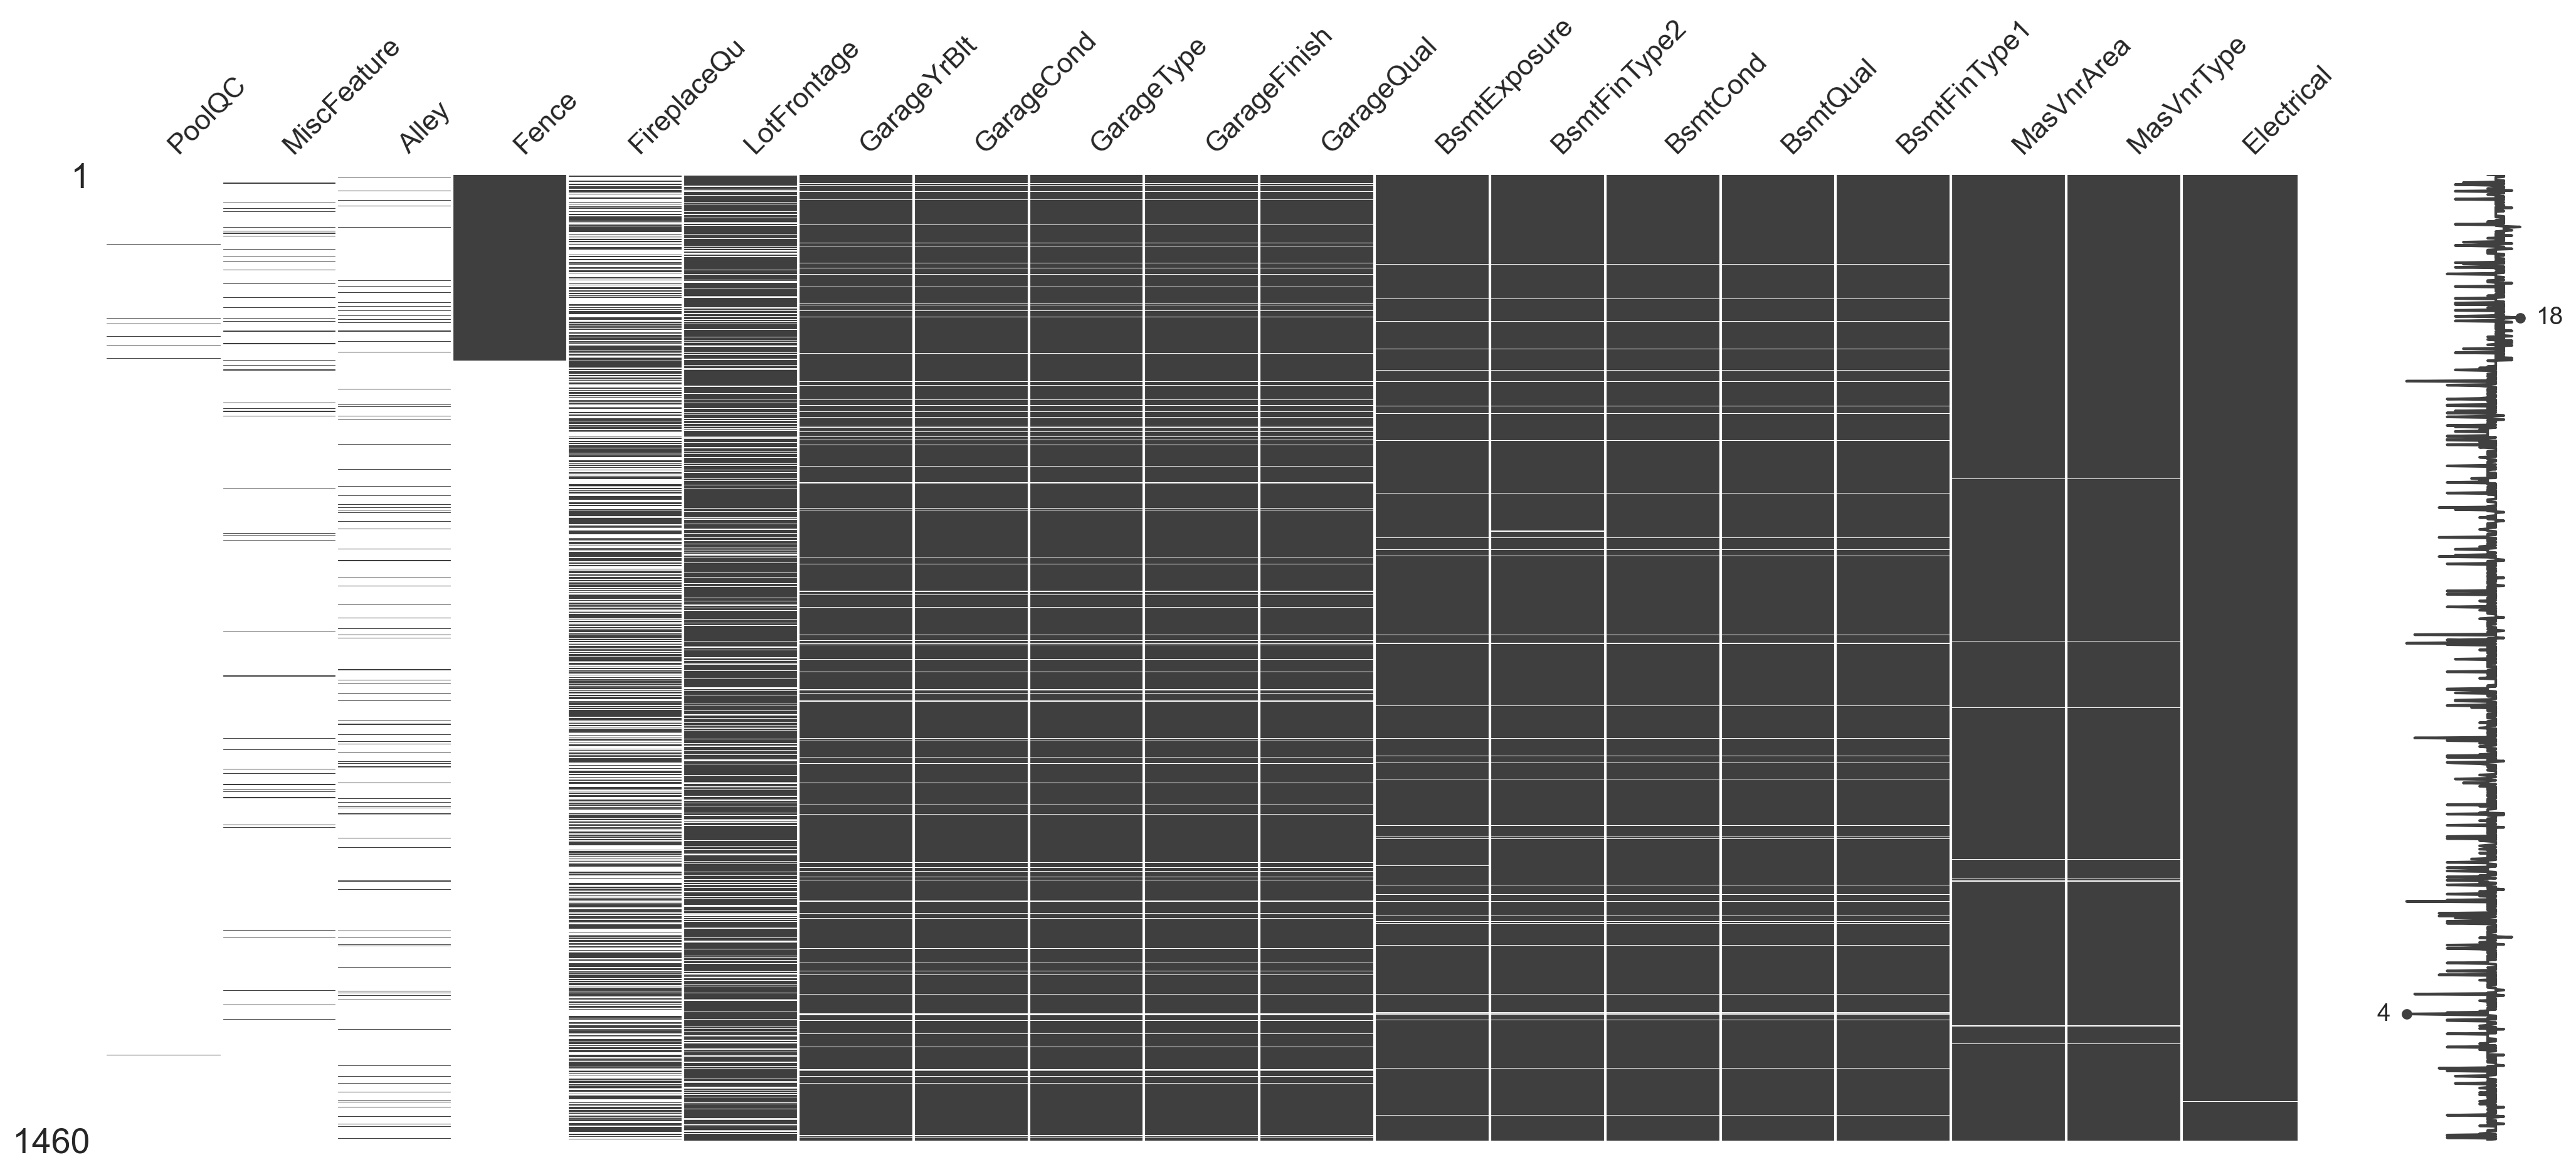

In [7]:
#msno.matrix(df_houses[missing_vals.index].sort_values(by='LotFrontage'))
msno.matrix(df_houses[missing_vals.index].sort_values(by='Fence'));

The graph shows that, as expected, there is a relationship in the appearance of missing values ​​for three groups of columns: those related to the garage, the basement, and the two to the masonry. Also seen is the number of known values ​​for each row, which ranges between 4 and 18.

Another type of graph that can be interesting in this sense is a heat map with the correlation of the variables. In this case, the data is converted to binary, indicating whether the value is known or not, and the correlation of these values ​​is calculated.

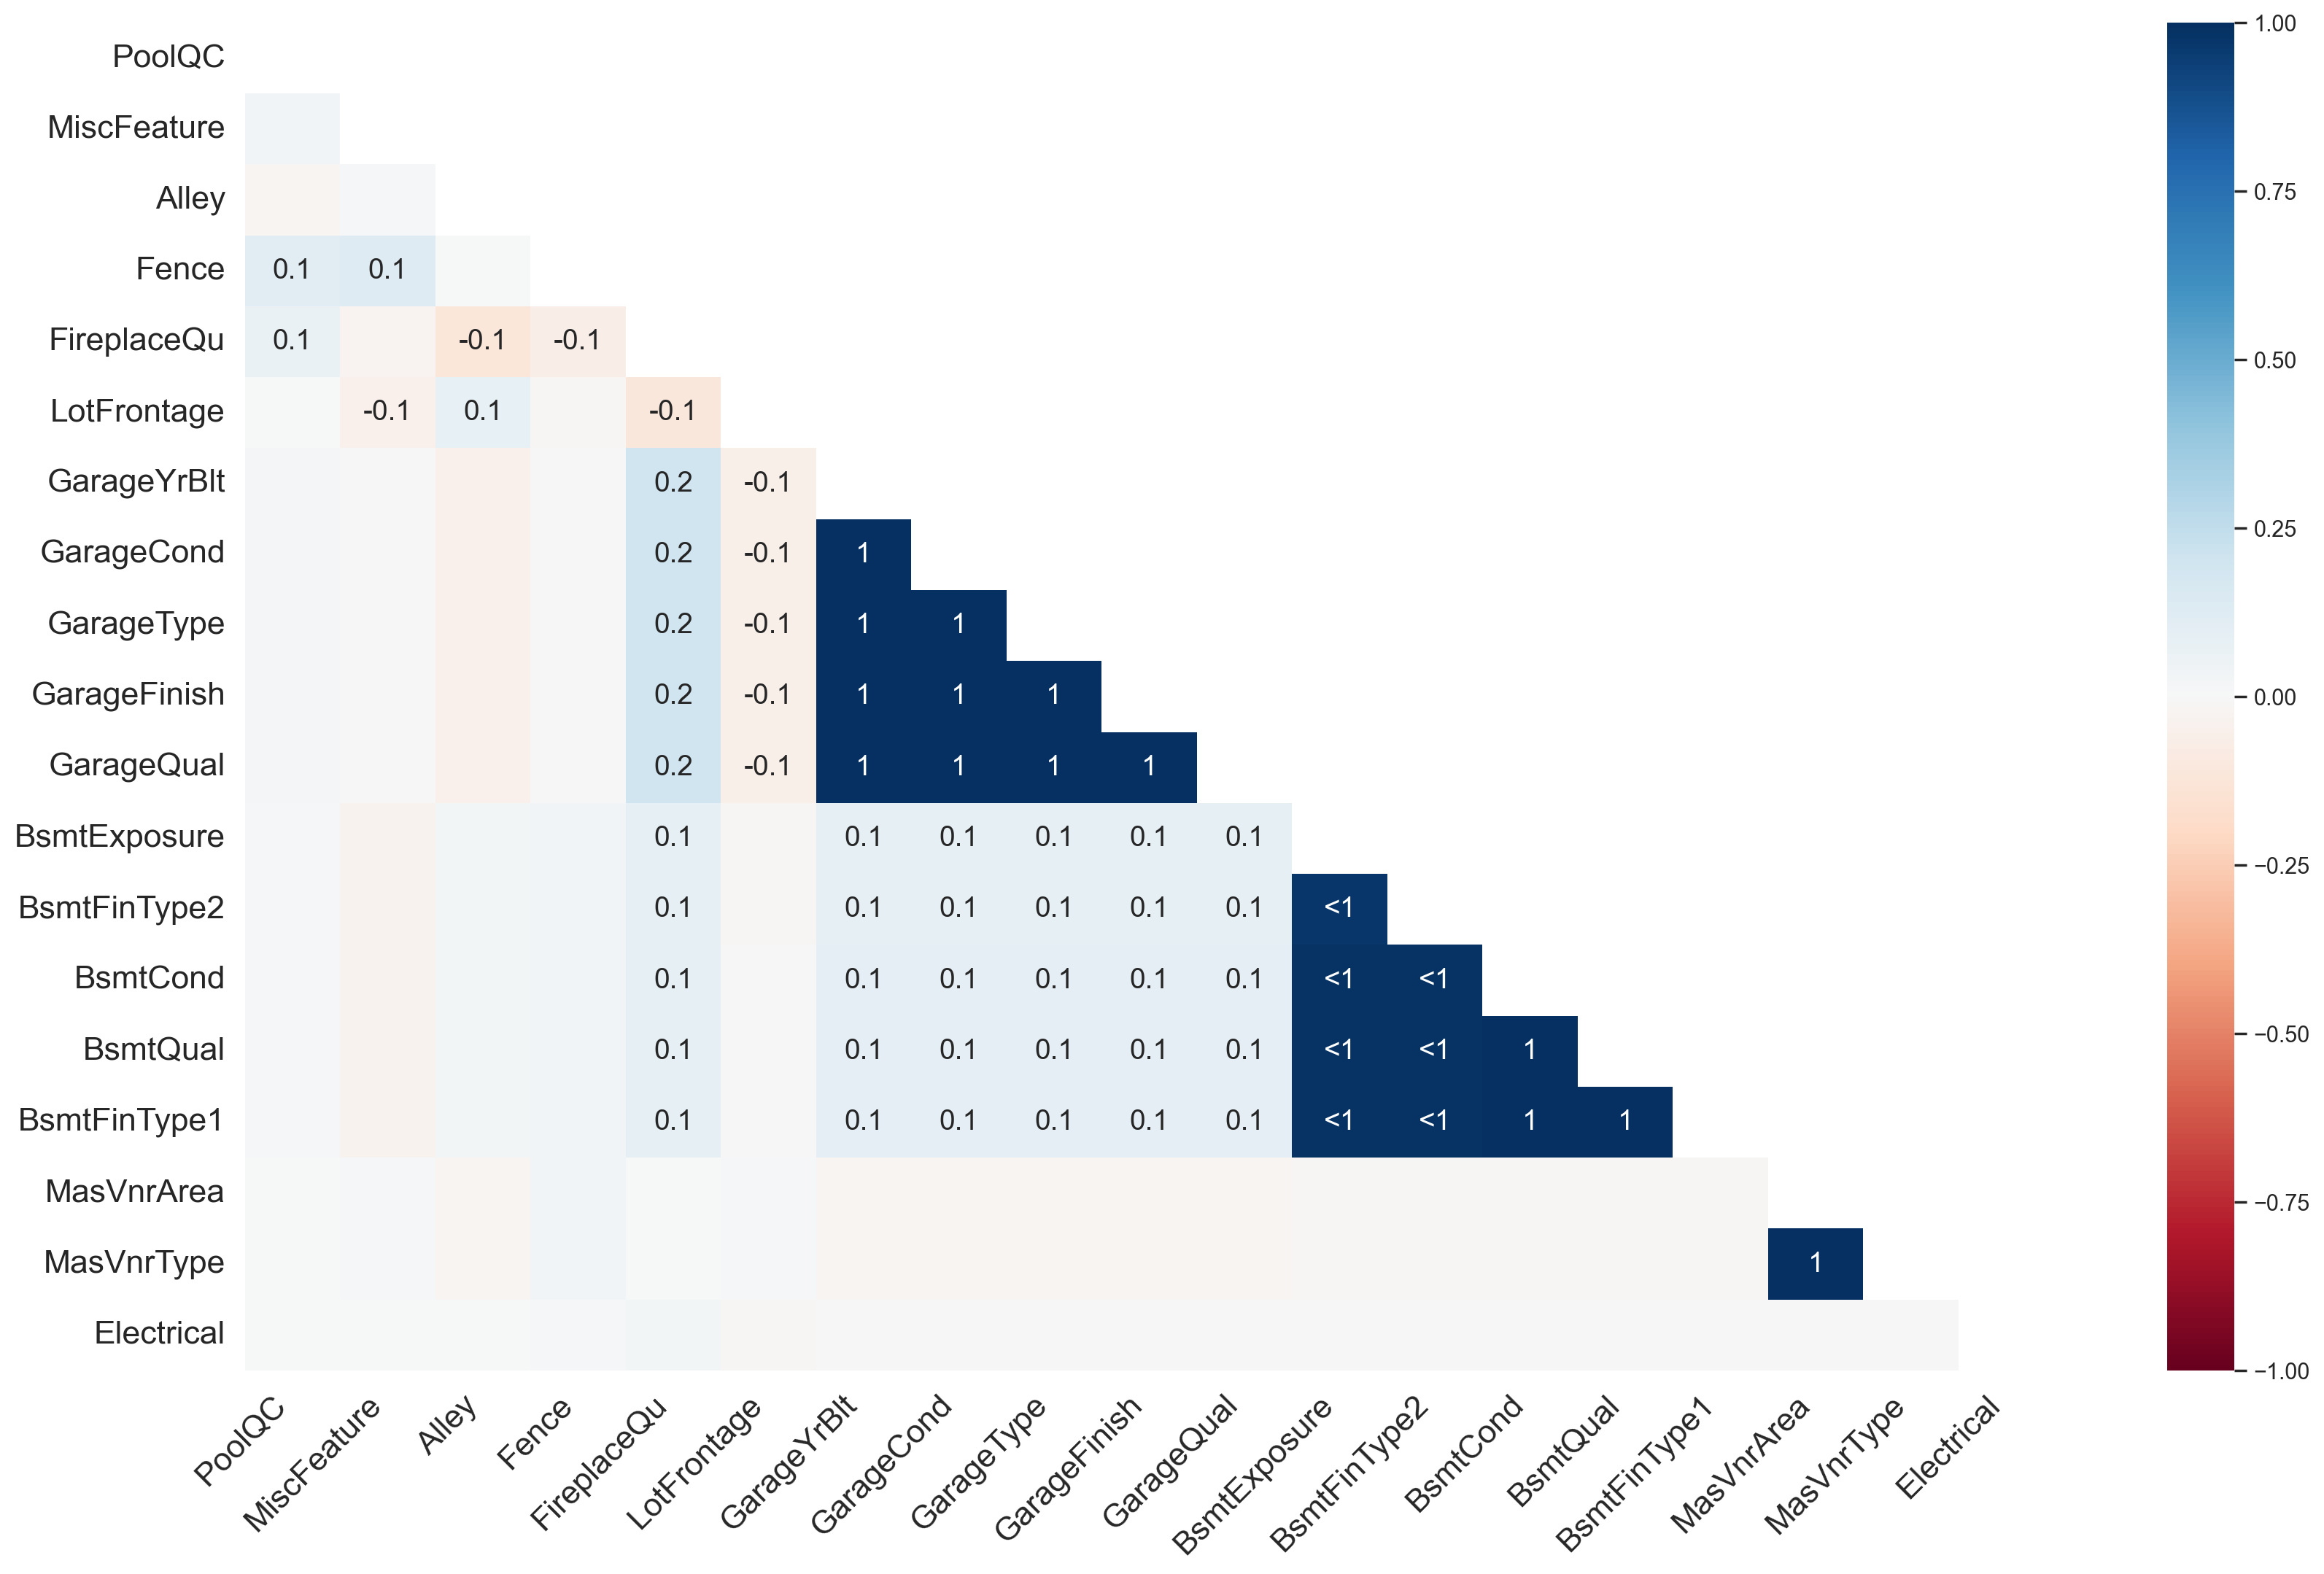

In [8]:
msno.heatmap(df_houses[missing_vals.index]);

The same can be seen as in the previous graph. Furthermore, it is seen that there is a certain correlation between the existence of a garage or basement. Also between the existence of a fire extinguisher in relation to these last two circumstances.

It can be seen that there are 19 characteristics for which there is missing data. The treatment given to each of them depends on their category. For example, in ordinals, `NA` always represents the lowest category (according to the file `data/data_description.txt`). Therefore, it can be coded as another category. Since the value $1$ has previously been assigned to the lowest category, the value 0 can be imputed.

In [9]:
df_houses[ordinal] = df_houses[ordinal].fillna(0)
df_houses.isna().sum().sort_values(ascending=False).where(lambda n: n>0).dropna()

MiscFeature    1406.0
Alley          1369.0
LotFrontage     259.0
GarageYrBlt      81.0
GarageType       81.0
MasVnrType        8.0
MasVnrArea        8.0
Electrical        1.0
dtype: float64

For discrete columns, `NA` is also a category that generally represents the **nonexistence** of an element.

In [10]:
df_houses[discrete] = df_houses[discrete].fillna('None')
df_houses.isna().sum().sort_values(ascending=False).where(lambda n: n>0).dropna()

LotFrontage    259.0
GarageYrBlt     81.0
MasVnrArea       8.0
dtype: float64

Once these values ​​are removed, three numeric columns remain that contain missing values. The first one, `LotFrontage`, is special, since it could represent missing values ​​as such or that there is no access to the street. The description shows us that there is no value equal to zero among the known values.

In [11]:
df_houses['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

It is interesting to note the values ​​that some related columns take in cases where `LotFrontage` is null.

In [12]:
df_houses[df_houses['LotFrontage'].isna()][['LotFrontage','LotArea','MSZoning','Street','Alley']].sort_values(by='LotArea', ascending=False)

,LotFrontage,LotArea,MSZoning,Street,Alley
Id,,,,,
336,NaN,164660,RL,Grvl,None
250,NaN,159000,RL,Pave,None
707,NaN,115149,RL,Pave,None
1397,NaN,57200,RL,Pave,None
458,NaN,53227,RL,Pave,None
...,...,...,...,...,...
976,NaN,2651,FV,Pave,None
181,NaN,2117,FV,Pave,None
1359,NaN,2117,FV,Pave,None


Nothing strange is seen. It is also interesting to see if any housing corresponds to agricultural land (`MSZoning=A`).

In [13]:
df_houses[df_houses['LotFrontage'].isna()]['MSZoning'].value_counts()

RL    229
RM     19
FV      8
RH      3
Name: MSZoning, dtype: int64

It can be seen that the relative values ​​`LotArea` (lot area) or the type of street do exist. This suggests that the best decision is to allocate the lost value. A simple strategy is to use the median of the values. However, it could be thought that there must be a certain correlation between the area of ​​the lot `LotArea` and the length of the facade that faces the street `LotFrontage`.

Correlación: 0.43


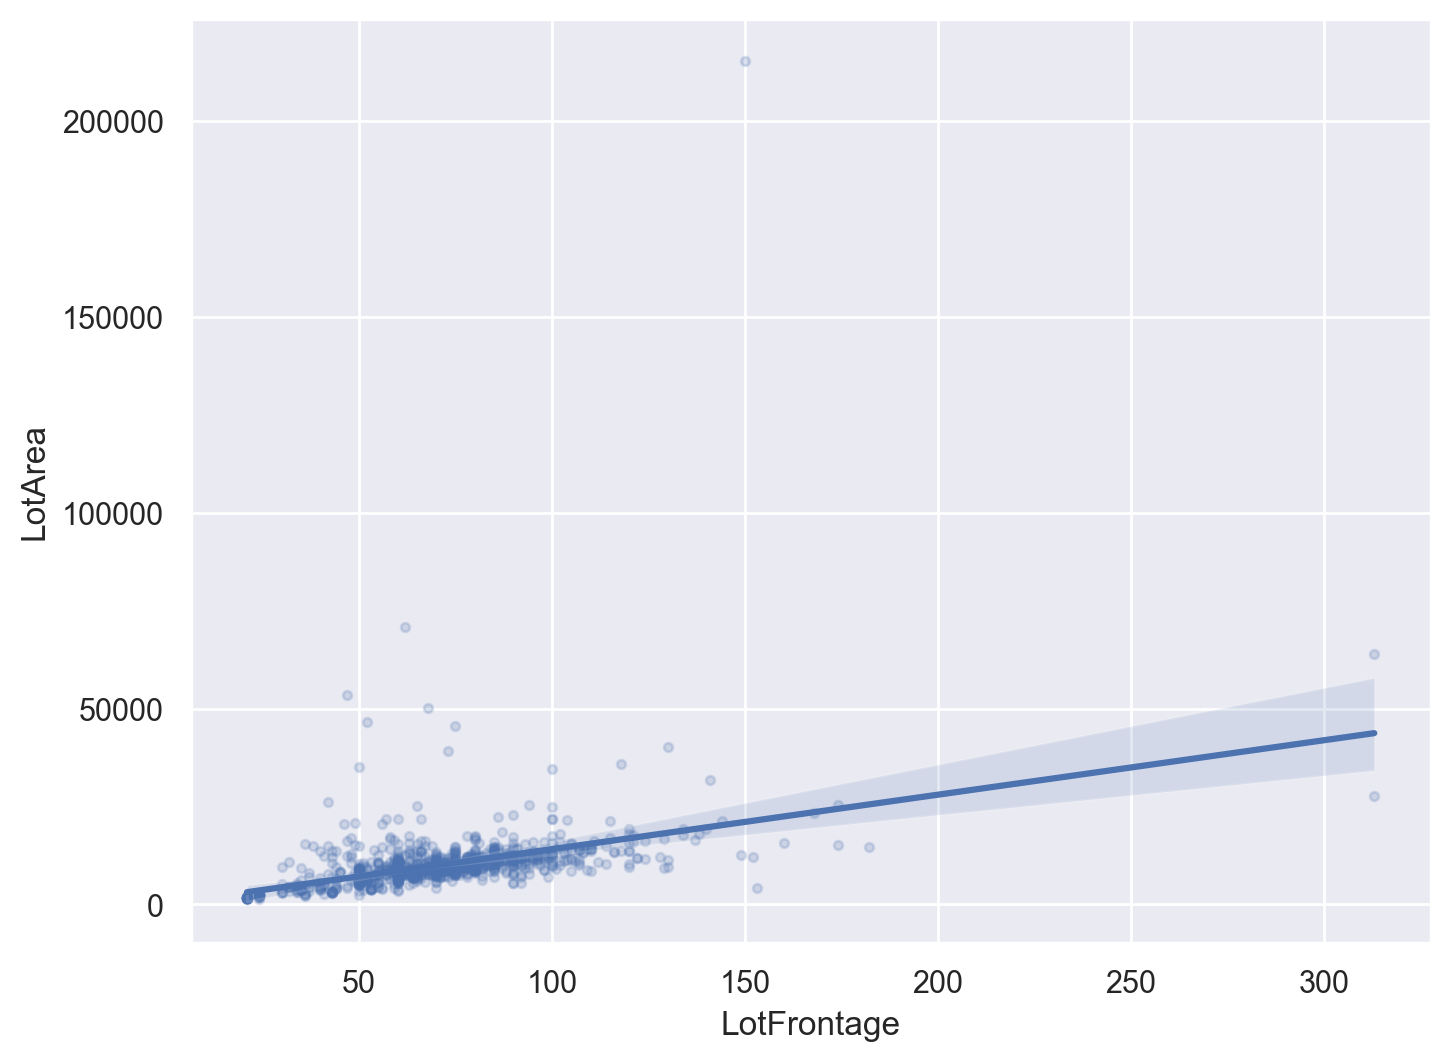

In [14]:
print(f"Correlación: {df_houses['LotFrontage'].corr(df_houses['LotArea']):.2f}")
plt.figure(figsize=(8,6))
sns.regplot(x=df_houses['LotFrontage'], y=df_houses['LotArea'],scatter_kws={'s':10, 'alpha':0.2});

The graph shows that indeed, and despite the outliers, there is a certain correlation, although it is not excessively high (0.43). For the sake of simplicity, and since the difference will not be too substantial (and we are not competing), the median could be used to impute the missing values.

In [15]:
#df_houses['LotFrontage'] = df_houses['LotFrontage'].fillna(df_houses['LotFrontage'].median())

<div class="alert alert-block alert-danger">

<i class="fa fa-info-circle" aria-hidden="true"></i> Actually here, strictly speaking, we incur a **data leak**. Given that the intention is to impute the median of the entire attribute before performing the partitioning into training and testing, in the preparation/learning pipeline instances would be used that can only be used at the time of prediction and reporting of results.
</div>

The next variable to study is `GarageYrBlt`. The presence of the value is informative, since it is associated with the existence or not of a garage. Since this information is already provided by two other variables `GarageFinish` and `GarageType`, it is advisable to distort the data as little as possible. In this case, we can impute the minimum value of the column.

In [16]:
#df_houses['GarageYrBlt'] = df_houses['GarageYrBlt'].fillna(df_houses['GarageYrBlt'].min())

<div class="alert alert-block alert-danger">

<i class="fa fa-info-circle" aria-hidden="true"></i> Strictly speaking, here too (to calculate the minimum).
</div>

The last variable, `MasVnrArea` corresponds to the masonry veneer area. A look at the missing values ​​along with the `MasVnrType` column provides information regarding that feature.

In [17]:
df_houses[df_houses['MasVnrArea'].isna()][['MasVnrArea','MasVnrType']]

,MasVnrArea,MasVnrType
Id,,
235,NaN,None
530,NaN,None
651,NaN,None
937,NaN,None
974,NaN,None
978,NaN,None
1244,NaN,None
1279,NaN,None


It seems that the missing values ​​correspond to the non-existence of masonry. Therefore, the value 0 will be imputed.

In [18]:
df_houses['MasVnrArea'] = df_houses['MasVnrArea'].fillna(0)

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Important__: It is not bad to remember that we have worked with the complete data set because we have precise information about the values ​​that each variable can take. In reality (we remember), these transformations and imputations would have to be done in a *pipeline* on the training set in order to process the new data. This option is presented as optional at the end, but we have decided to present the capstone this way to simplify your work.
<br><br>


With this reservation made, taking into account that we assume that training and test data come from the same distribution, that the impact of the parts where there is data leakage is minimal, and also <**>with the intention of simplifying your work<** >, we will impute the values ​​of the two columns that we had left for later.
</div>

In [19]:
df_houses['LotFrontage'] = df_houses['LotFrontage'].fillna(df_houses['LotFrontage'].median())
df_houses['GarageYrBlt'] = df_houses['GarageYrBlt'].fillna(df_houses['GarageYrBlt'].min())

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section3"></a>
## <font color="#00586D"> 3. Preliminary exploration</font>
<br>


Since the ultimate objective of this project is prediction, and the number of variables is high, the exploration has to revolve around the class variable. Below is the distribution of the `SalePrice` column. It is observed that the distribution is skewed to the left, and that there are extreme values. It may be necessary to take this circumstance into account when developing the models.

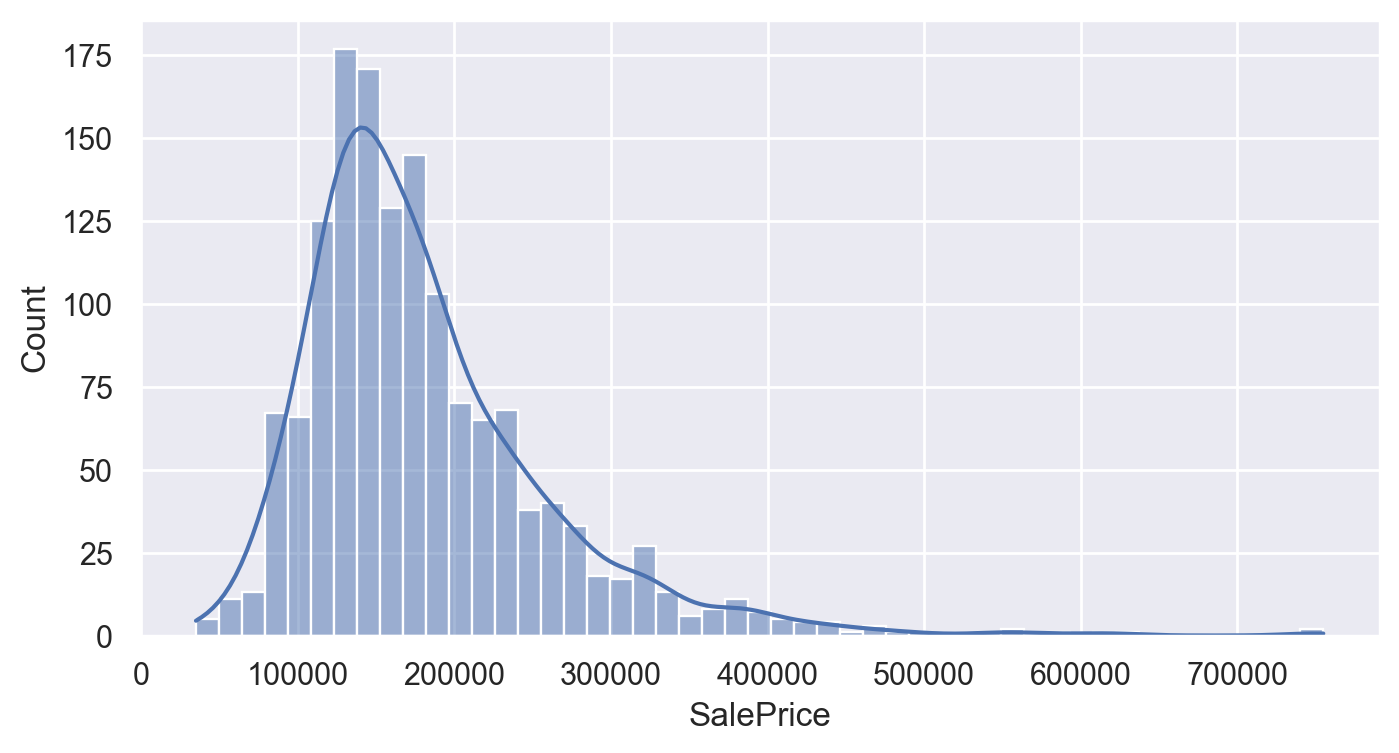

In [20]:
plt.figure(figsize=(8,4))
sns.histplot(x=df_houses['SalePrice'], kde=True);

---

### <font color="#00586D">Exploration on variables related to housing prices</font>
<br>

As the number of variables is high, and taking into account the objective, we will initially stop at those most correlated (positively or negatively) with the sale price 'SalePrice'. First, numerical and ordinal will be explored.

In [21]:
(df_houses.corr()['SalePrice']).nlargest(20) # Positiva
#(df_houses.corr()['SalePrice']).nsmallest(20) # Negativa

C:\Users\laura\AppData\Local\Temp\ipykernel_4864\77623581.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df_houses.corr()['SalePrice']).nlargest(20) # Positiva


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
GarageFinish    0.549247
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
FireplaceQu     0.520438
GarageYrBlt     0.518287
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
HeatingQC       0.427649
Name: SalePrice, dtype: float64

For example, the 20 with the most correlation (positive or negative) will be considered using the absolute value.

In [22]:
relevant_num_feat = (df_houses.corr()['SalePrice']).map(np.abs).nlargest(20)
relevant_num_feat

C:\Users\laura\AppData\Local\Temp\ipykernel_4864\908728054.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  relevant_num_feat = (df_houses.corr()['SalePrice']).map(np.abs).nlargest(20)


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
GarageFinish    0.549247
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
FireplaceQu     0.520438
GarageYrBlt     0.518287
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
HeatingQC       0.427649
Name: SalePrice, dtype: float64

It can be seen that the strongest correlations are positive, and that the correlation is above 0.5 in some cases. Their names (excluding `SalePrice`) will be stored for *possible* later use.

In [23]:
import pickle

relevant_num_feat = relevant_num_feat[relevant_num_feat>0.5].index.to_list()[1:]#  Deja fuera `SalePrice`
print(relevant_num_feat)

# Guarda la información
with open('data/relevant.pickle', 'wb') as file:
    pickle.dump(relevant_num_feat, file)

['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'FullBath', 'GarageFinish', 'TotRmsAbvGrd', 'YearBuilt', 'FireplaceQu', 'GarageYrBlt', 'YearRemodAdd']


Next, the first 5 characteristics of `relevant_num_feat` (the most correlated) and `SalePrice` are explored using a figure of type `PairPlot`.

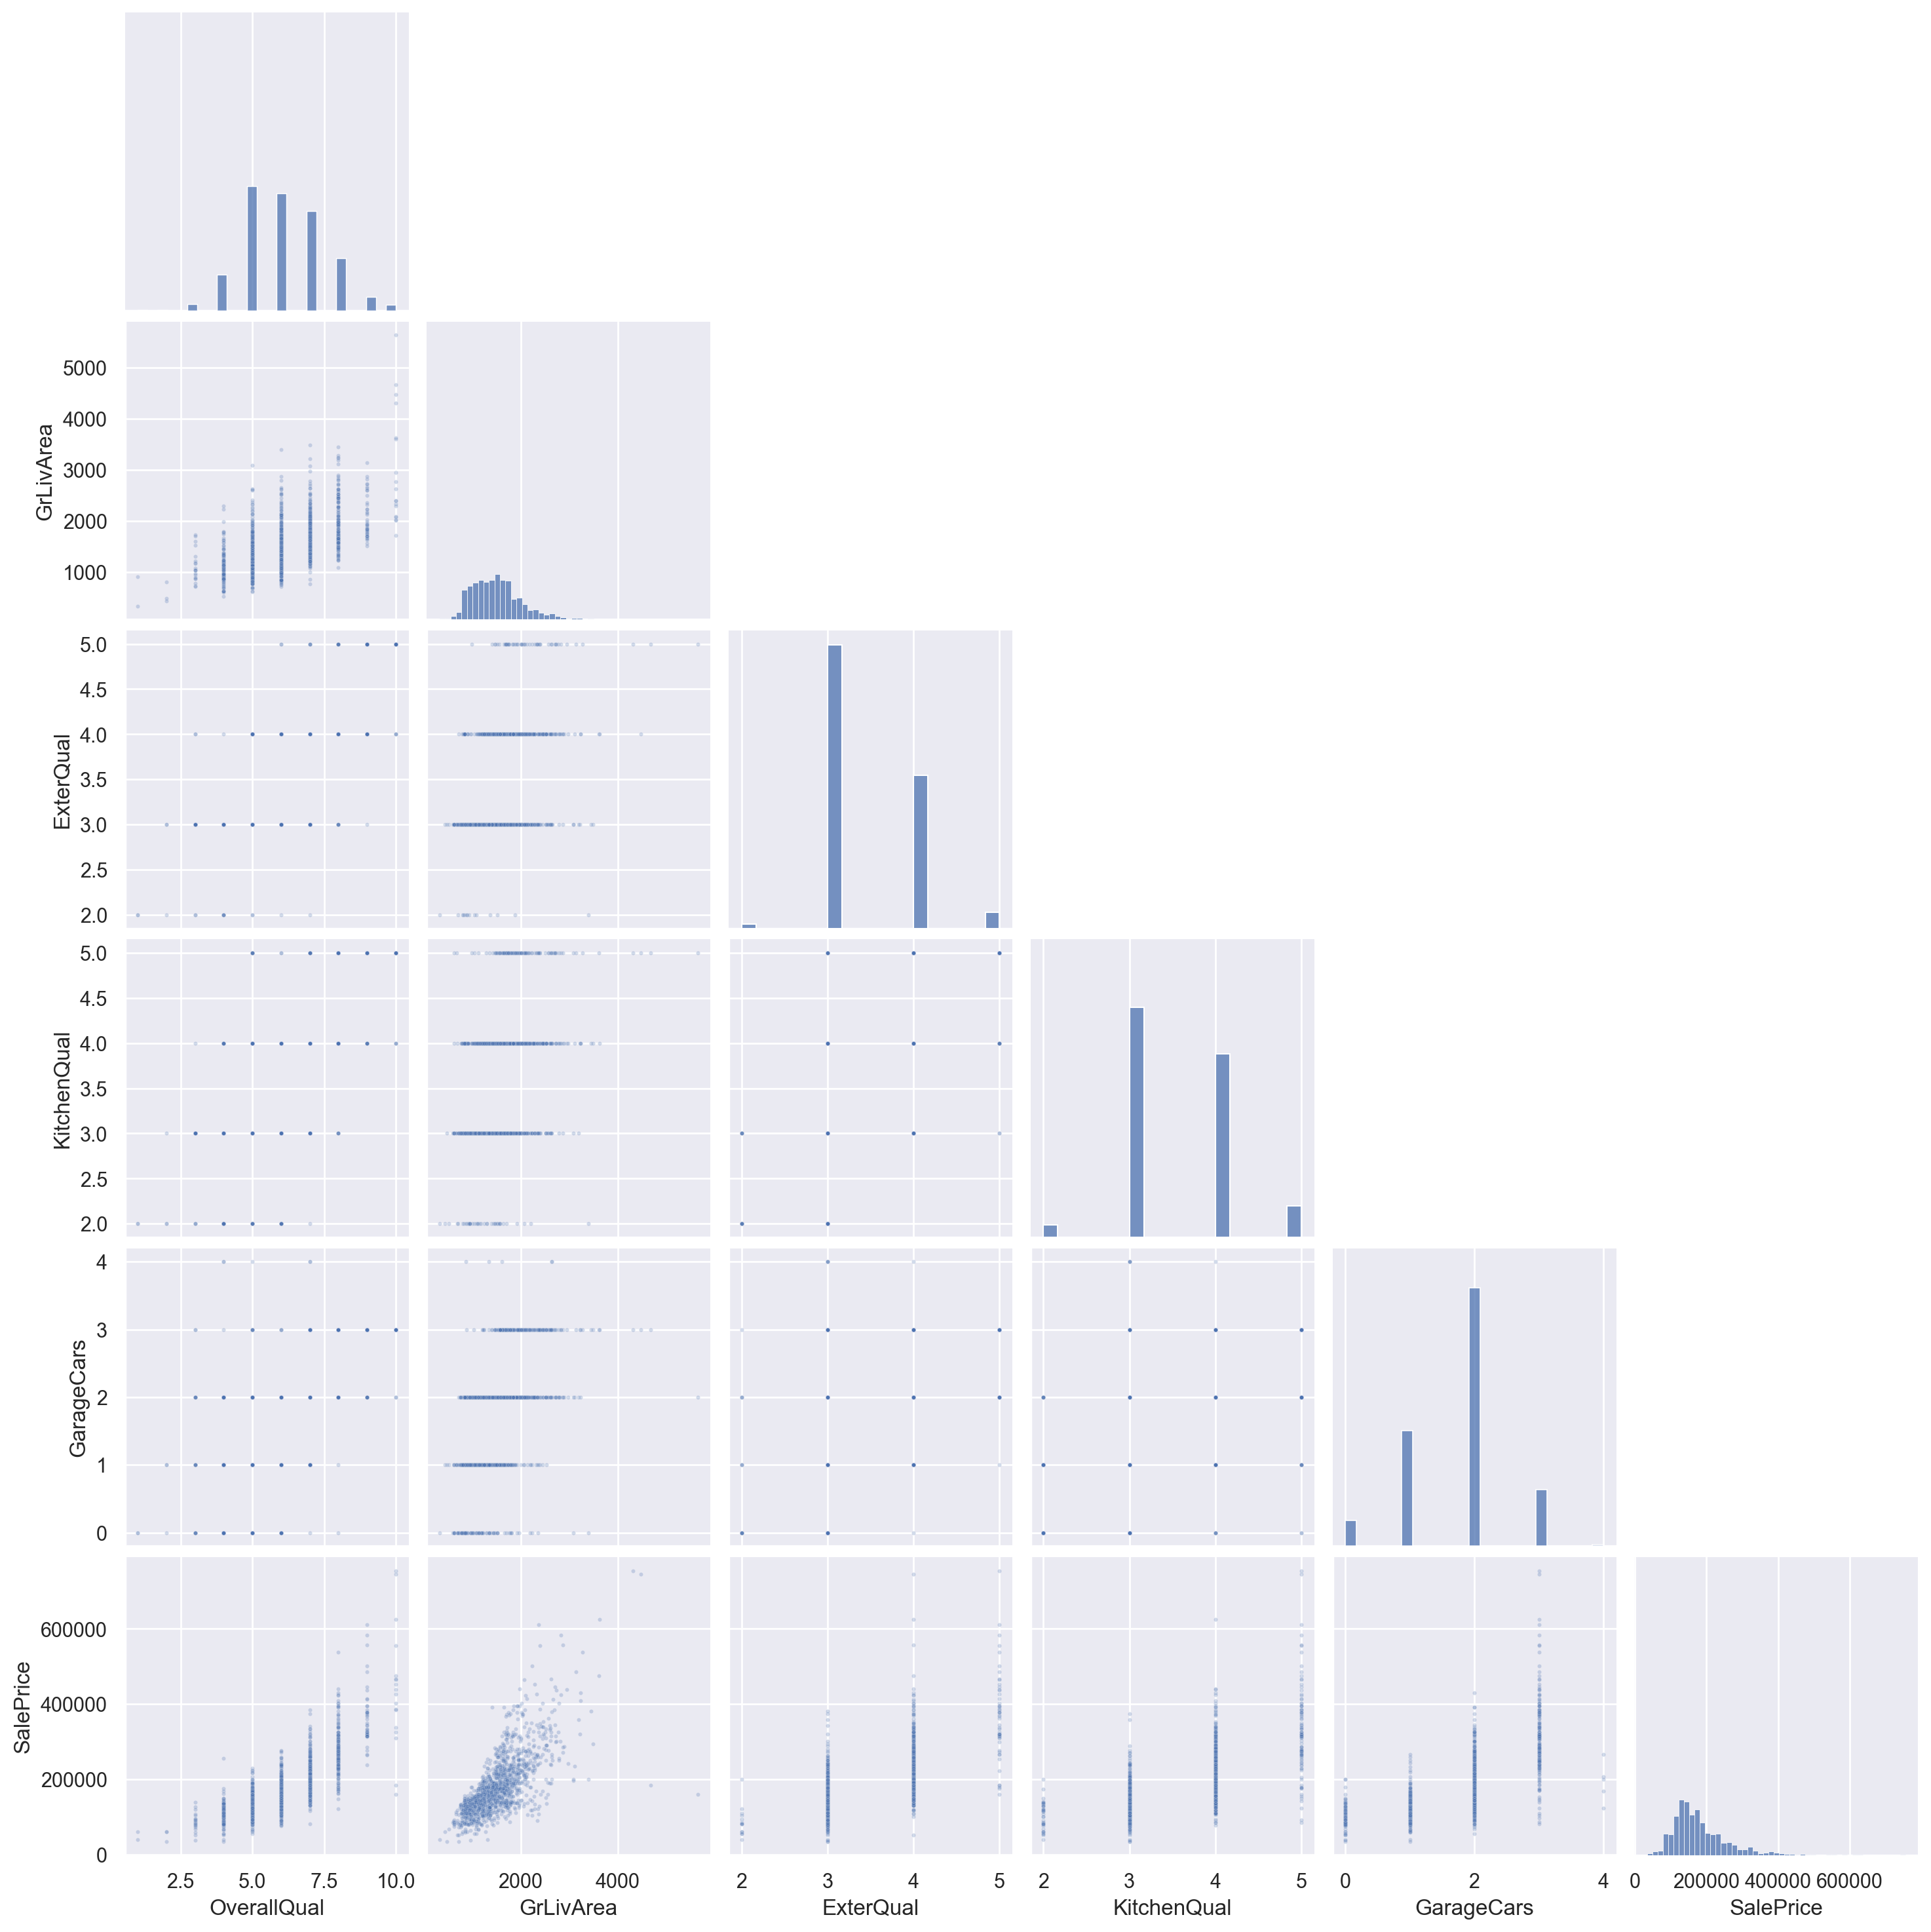

In [24]:
sns.pairplot(df_houses[relevant_num_feat[0:5]+['SalePrice']], corner=True,  plot_kws={'s':5,'alpha':0.25});

Some details can be seen in the graph, in addition to the correlation that had been previously obtained. One of them is that the distribution of values ​​of `GrLivArea` (the area of ​​the house excluding the basement) is also (slightly) skewed. On the other hand, the value of the sale price varies more as the value of other variables such as `OverallQual` or `GarageCars` increases (*homoscedasticity* does not occur).

The relationship between `OverallQual` and `SalePrice` *seems like it might not be*linear. The following figure shows this relationship, and the relationship of `OverallQual` to the logarithm of `SalePrice`.

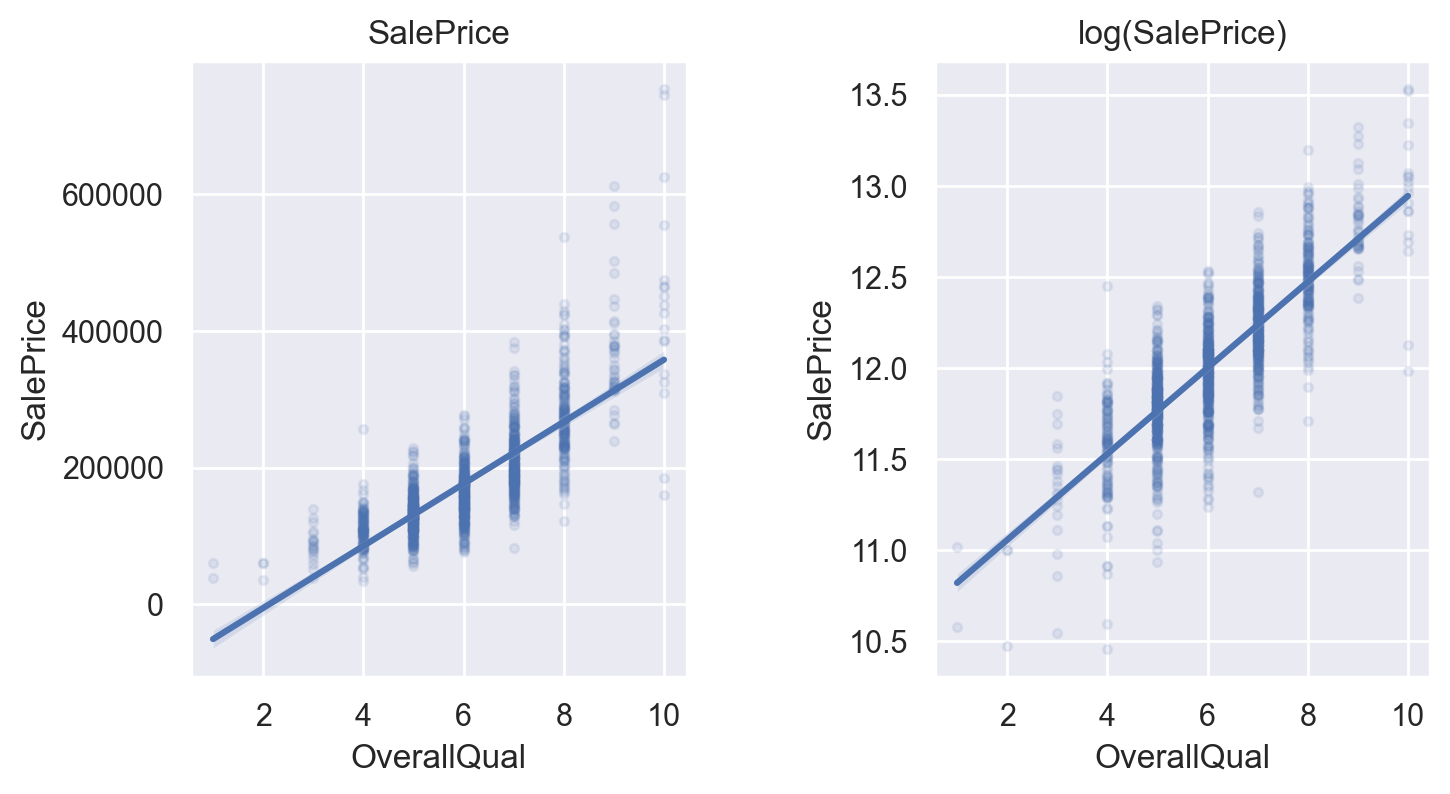

In [25]:
f, axes_grid = plt.subplots(1,2, figsize=(8,4))
sns.regplot(x=df_houses['OverallQual'], y=df_houses['SalePrice'], scatter_kws={'s':10, 'alpha':0.1}, ax = axes_grid[0]);
sns.regplot(x=df_houses['OverallQual'], y=np.log(df_houses['SalePrice']), scatter_kws={'s':10, 'alpha':0.1}, ax = axes_grid[1]);
axes_grid[0].set_title('SalePrice')
axes_grid[1].set_title('log(SalePrice)')
plt.subplots_adjust( wspace=0.5)

It seems that, indeed, the second graph represents the relationship better, although *the difference is very subtle*.

In relation to categorical variables, the analysis can be more laborious. Below, a box plot is drawn for each of the categorical variables in order to intuit some relationship. To see the trends more clearly, the categories can be ordered by the median.

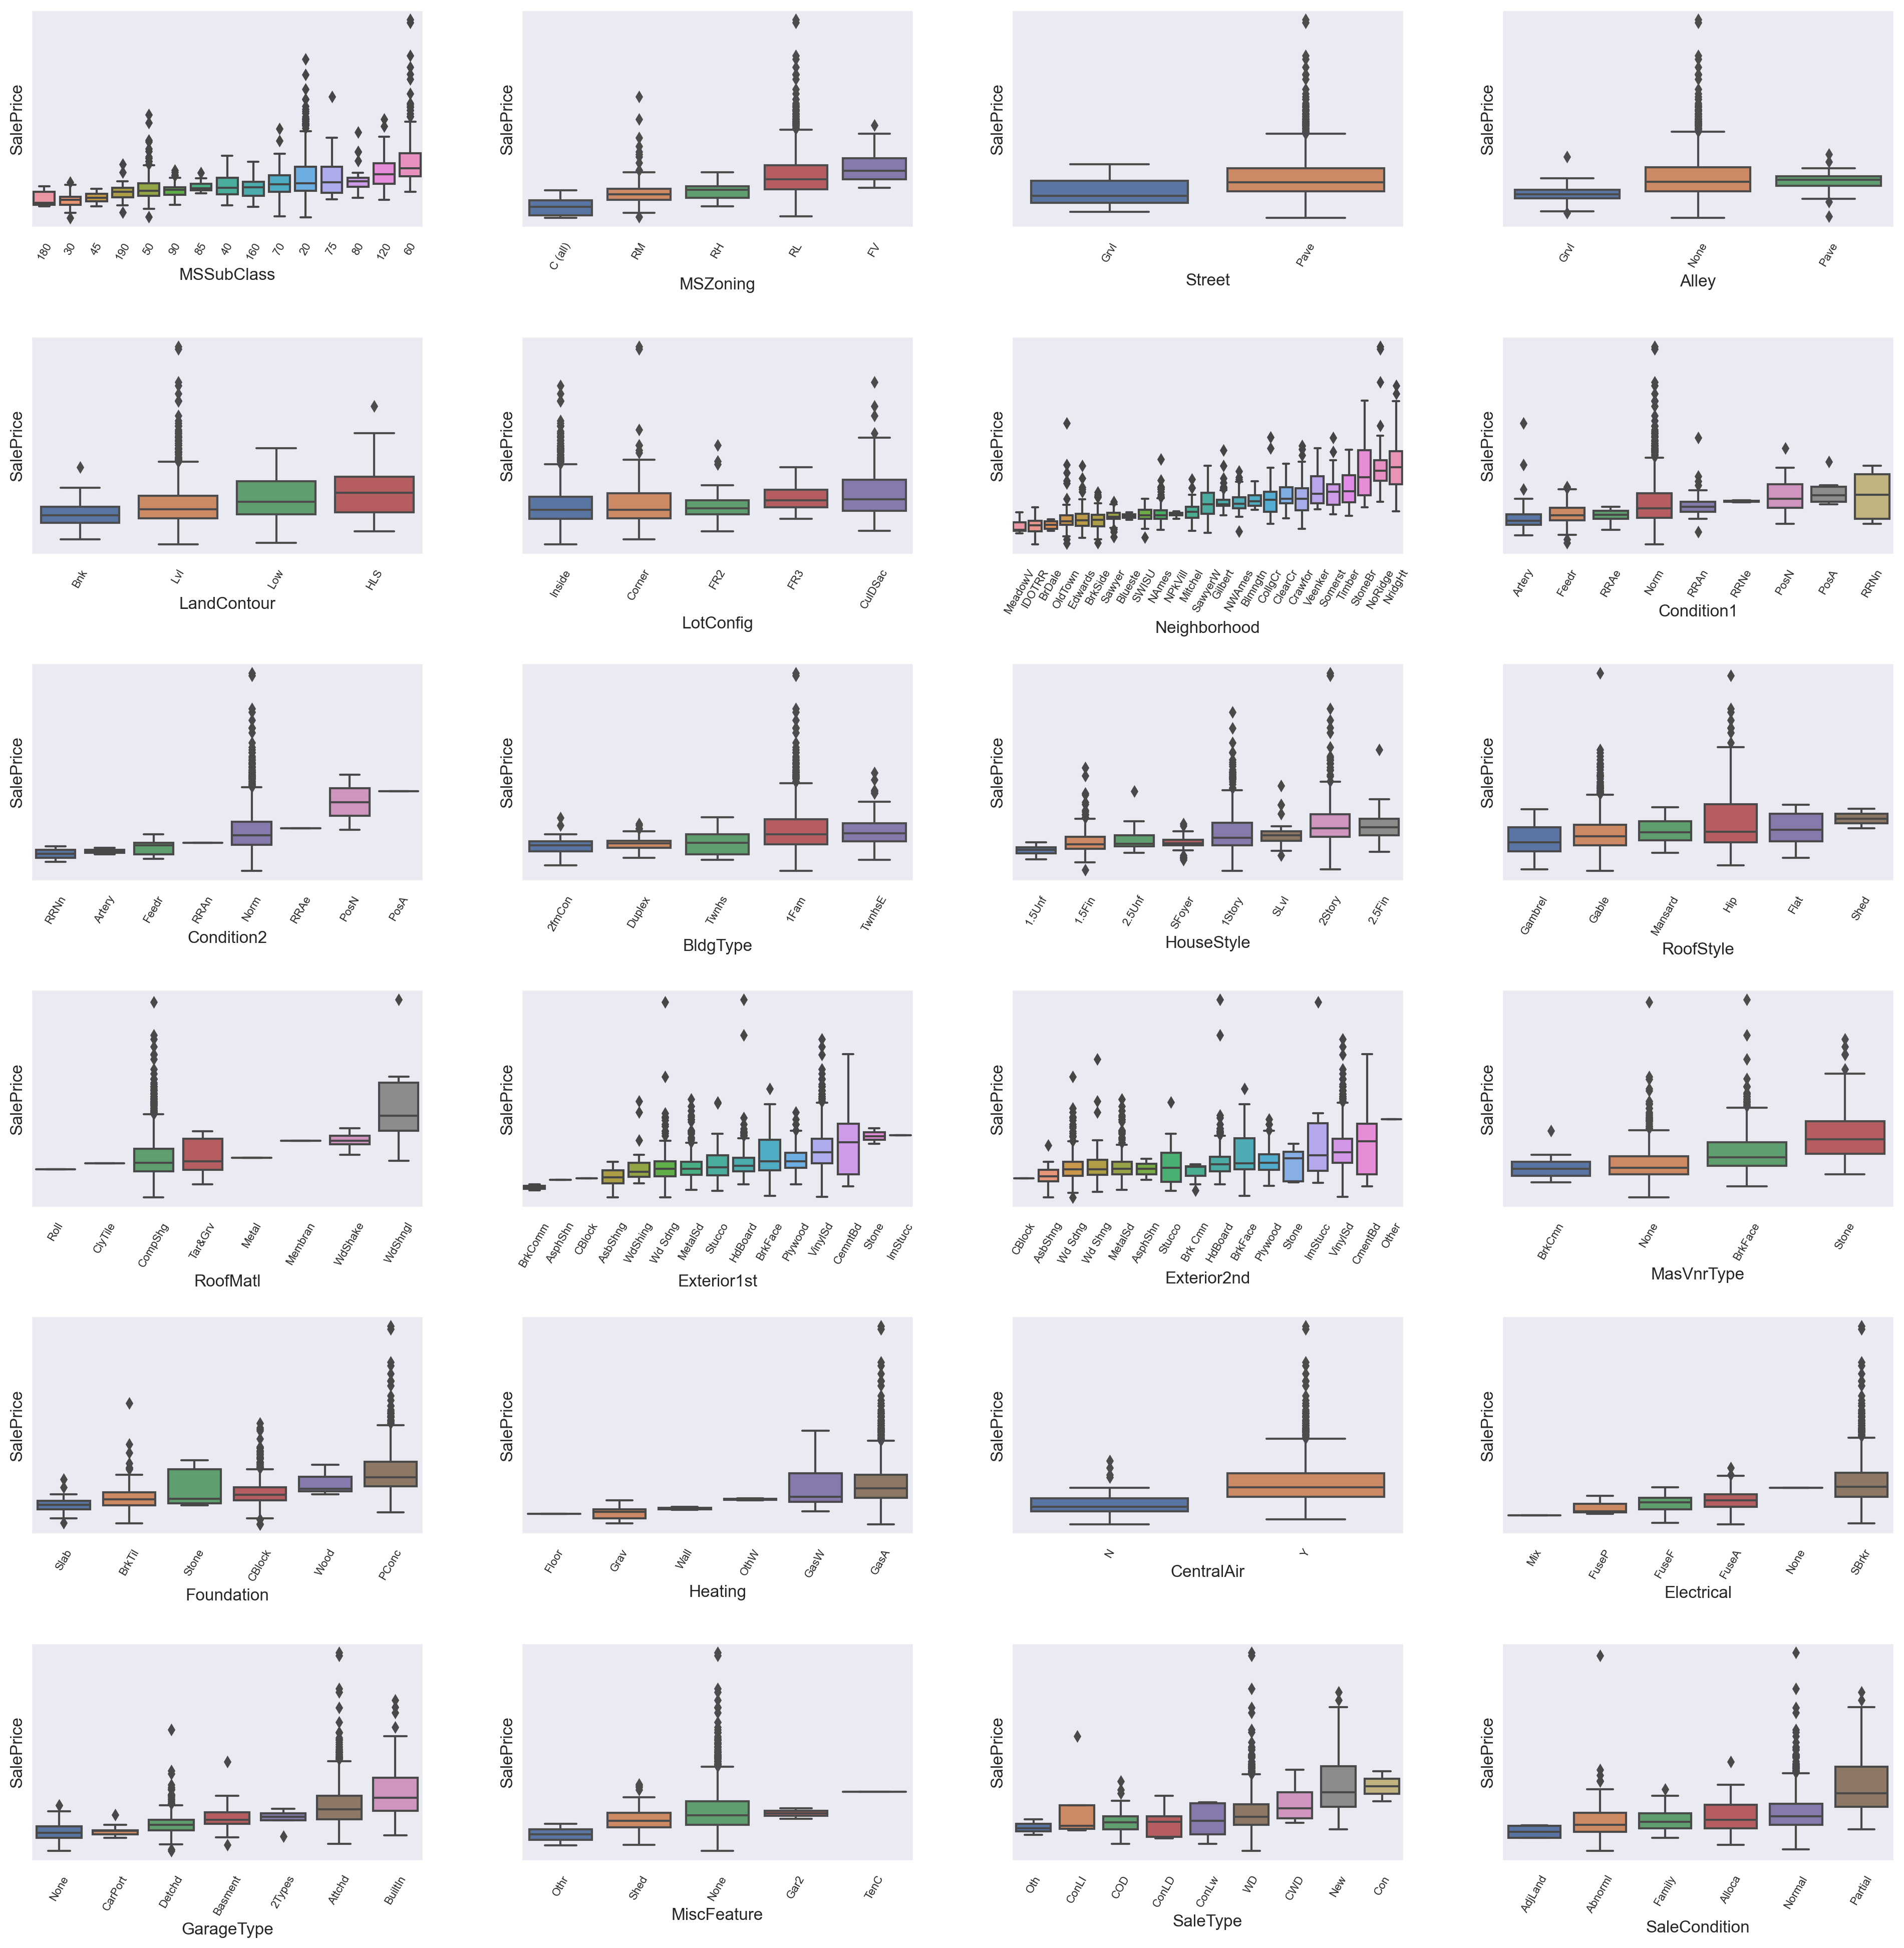

In [26]:
f, axes_grid = plt.subplots(6,4, figsize=(24,24))

for column,ax in zip(discrete,axes_grid.flatten()):
    order = df_houses.groupby(column)['SalePrice'].median().sort_values().index.to_list()
    sns.boxplot(data=df_houses, x=column, y='SalePrice', order=order, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, fontsize=8)
    ax.set_yticks([]) 
    
plt.subplots_adjust(hspace=0.5, wspace=0.25)

Although the variability does not allow the trends to be clearly appreciated, the influence of the discrete variable on the price is clearly appreciated in the case of characteristics such as `Neighborhood`, `LandContour`, `MSZoning` or others. In other cases, such as `SaleCondition`, no difference is seen except in one of the categories (`Partial`).

Another way to see the influence of discrete variables on price, also related to how they are encoded in the learning model, is by doing a *One Hot* encoding (with pd.get_dummies) and calculating the correlation with ` SalePrice`.

In [27]:
pd.concat([pd.get_dummies(df_houses[discrete]), df_houses['SalePrice']], axis=1).corr()['SalePrice'].nlargest(20)

SalePrice                1.000000
Foundation_PConc         0.497734
Neighborhood_NridgHt     0.402149
SaleType_New             0.357509
SaleCondition_Partial    0.352060
GarageType_Attchd        0.335961
MasVnrType_Stone         0.330476
Neighborhood_NoRidge     0.330424
Exterior2nd_VinylSd      0.306389
Exterior1st_VinylSd      0.305009
CentralAir_Y             0.251328
MSZoning_RL              0.245063
HouseStyle_2Story        0.242880
Electrical_SBrkr         0.241896
RoofStyle_Hip            0.235897
GarageType_BuiltIn       0.235449
Neighborhood_StoneBr     0.215363
MasVnrType_BrkFace       0.198191
RoofMatl_WdShngl         0.169324
LotConfig_CulDSac        0.141818
Name: SalePrice, dtype: float64

In this case it is seen that the positive correlation corresponds to some values, such as the cement base (`Foundation_PConc`), a specific neighborhood (`Neighborhood_NridgHt`) or the type of sale (`SaleType_New` ). However, these correlations are not excessively relevant. You can also obtain those that have a negative impact.

In [28]:
pd.concat([pd.get_dummies(df_houses[discrete]), df_houses['SalePrice']], axis=1).corr()['SalePrice'].nsmallest(20)

MasVnrType_None        -0.367456
GarageType_Detchd      -0.354141
Foundation_CBlock      -0.343263
MSZoning_RM            -0.288065
CentralAir_N           -0.251328
SaleType_WD            -0.242598
GarageType_None        -0.236832
RoofStyle_Gable        -0.224744
Foundation_BrkTil      -0.204117
Electrical_FuseA       -0.193978
Neighborhood_OldTown   -0.192189
Neighborhood_NAmes     -0.188513
Neighborhood_Edwards   -0.179949
Exterior1st_MetalSd    -0.167068
Neighborhood_IDOTRR    -0.164056
HouseStyle_1.5Fin      -0.163466
Exterior2nd_MetalSd    -0.162389
Exterior2nd_Wd Sdng    -0.161800
Exterior1st_Wd Sdng    -0.158619
SaleCondition_Normal   -0.153990
Name: SalePrice, dtype: float64

The absence of masonry (`MasVnrType_None`), the detached garage (`GarageType_Detchd`), or some neighborhoods have a negative impact on the price of the home.

As the number of binary variables is very high in relation to the data set, and there is a risk of overfitting, we will keep the most relevant ones (positively or negatively) and they will be stored in `relevant_dum_feat` in case this information had to be used in some in later phases.

In [29]:
relevant_dum_feat = (pd.concat([pd.get_dummies(df_houses[discrete]), df_houses['SalePrice']], axis=1)
                   .corr()['SalePrice']
                   .apply(np.abs)
                   .nlargest(20)).index.to_list()[1:]

print(relevant_dum_feat)

# Guarda la información
with open('data/relevant_oh.pickle', 'wb') as file:
    pickle.dump(relevant_dum_feat, file)

['Foundation_PConc', 'Neighborhood_NridgHt', 'MasVnrType_None', 'SaleType_New', 'GarageType_Detchd', 'SaleCondition_Partial', 'Foundation_CBlock', 'GarageType_Attchd', 'MasVnrType_Stone', 'Neighborhood_NoRidge', 'Exterior2nd_VinylSd', 'Exterior1st_VinylSd', 'MSZoning_RM', 'CentralAir_Y', 'CentralAir_N', 'MSZoning_RL', 'HouseStyle_2Story', 'SaleType_WD', 'Electrical_SBrkr']


To finish, a data set will be created. The only transformation that has to be done is the one corresponding to the discrete variables, for which a *One Hot* transformation must be done. The resulting data set will be stored in the `data/houses_prep.csv` file.

In [30]:
data = pd.concat([df_houses[numerical+ordinal], pd.get_dummies(df_houses[discrete])], axis=1).copy()
data.to_csv('data/houses_prep.csv')

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<div align="right">
<a href="#indice"><font size=6 color="#00586D"><i class="fa fa-coffee" aria-hidden="true"></i></font></a>
</div>